# Hyperparameters tuning of convolutional neuronal networks using particle swarm optimization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(1234)
import random as rn
rn.seed(12345)
import os
os.environ['PYTHONHASHSEED'] = '0' 
from keras import backend as K

import math
import time
from datetime import timedelta
import optunity
import optunity.metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Funciones adicionales para graficar (blackbox)
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    fig.savefig('plot_images.pdf')

def print_accuracy():   
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
    
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    fig.savefig('plot_weights.pdf')

## MNIST Dataset

Se utiliza el conjunto de datos MNIST, el cual contiene 70.000 imagenes de 28x28 pixeles y las etiquetas verdaderas correspondientes. Cada una de las imagenes contiene un número del 0 al 9 escritos a mano, la etiqueta es un vector de 10 elementos con un uno en la ubicación (índice) que se corresponde con el valor representado en la imagen y los demas elementos en cero (codificacion "one-hot").

Este conjunto de datos se divide en tres subconjuntos:

- Entrenamiento
- Test
- Validación

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
data.test.cls = np.array([label.argmax() for label in data.test.labels])
#data.test.cls = np.argmax(data.test.labels, axis=1)
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## <a name="inData"></a> Dimnsiones de los datos 
Se declaran variables que serán utilizadas a lo largo del código y que definen las dimensiones de los datos. Además, se muestran algunas imágenes del set de datos que se esta utilizando.

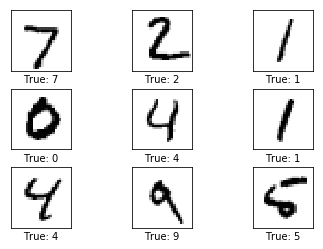

In [4]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Number of images per batch
batch_size = 128

# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [5]:
## Create the neural network with these hyper-parameters
def create_model (learningRate,
                  denseLayerNodes,
                  FilterSize,
                  FiltersNode,
                  LayerAct):
    
    # Start construction of the Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(InputLayer(input_shape=(img_size_flat,)))

    # The input is a flattened array with 784 elements,
    # but the convolutional layers expect images with shape (28, 28, 1)
    model.add(Reshape(img_shape_full))

    for numLayers in range(0,len(FilterSize)): 
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(numLayers+1)

        # Add convolutional layer with max-pooling.
        model.add(Conv2D(kernel_size=FilterSize[numLayers],
                         strides=1, filters=FiltersNode[numLayers], padding='same',
                         activation=LayerAct[numLayers], name=name))
        if(LayerAct[numLayers] == 'linear'):
            model.add(LeakyReLU(alpha=.001))   # add an advanced activation    
        model.add(MaxPooling2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected / dense layer.
    model.add(Flatten())

    # First fully-connected / dense layer with LeakyReLU-activation.
    model.add(Dense(denseLayerNodes, activation='linear'))
    model.add(LeakyReLU(alpha=.001))   # add an advanced activation    

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use the Adam method for training the network.
    optimizer = Adam(lr=learningRate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return(model)

## Optimización de hiperparámetros

### Espacio de búsqueda
 
 Los hiperparámetros a optimizar son:
 
- $num\_dense\_layers$: número de capas de la red.
- $activation$: método de activación de las neuronas en cada capa, puede ser ReLU, Leaky ReLU, tanh o Sigmoid.
- $learning\_rate$: _learning rate_ del optimizador Adam.
- $num\_dense\_nodes$: número de neuronas en cada capa.

In [6]:
## Optunity PSO optimization search space
# Activation 
activation_cat = ['relu', 'sigmoid', 'tanh', 'linear']
# Maximum and minimum number of nodes or neurons
max_dense_nodes = 32 
min_dense_nodes = 1
# Maximum and minimum learning rate for the optimizer
max_learning_rate = 1e-2
min_learning_rate = 1e-6
# Maximum and minimum filter size
min_filter_size = 1
max_filter_size = 16
# Maximum and minimum filters
min_filters = 1
max_filters = 64

# Search space for the hiperparameters optimization
search = {'CNN': {'1CLayer': {'learningRate': [min_learning_rate, max_learning_rate],
                              'denseLayerNodes': [min_dense_nodes,max_dense_nodes],
                              'layer1Filters': [min_filters, max_filters],
                              'layer1FilterSize': [min_filter_size,max_filter_size],
                              'layer1_act': [0,3]
                             },
                  '2CLayer': {'learningRate': [min_learning_rate, max_learning_rate],
                              'denseLayerNodes': [min_dense_nodes,max_dense_nodes],                              
                              'layer1Filters': [min_filters, max_filters],
                              'layer1FilterSize': [min_filter_size,max_filter_size],
                              'layer1_act': [0,3],
                              'layer2Filters': [min_filters, max_filters],
                              'layer2FilterSize': [min_filter_size,max_filter_size],
                              'layer2_act': [0,3]
                             }
                 }
           }

In [7]:
## Calculate the fitness value
def calculate_fitness (learningRate,
                       denseLayerNodes,
                       FilterSize,
                       FiltersNode,
                       LayerAct):
    # number of folds
    k = 5 
    # calculate the fold size
    n_samples = len(data.train.images)
    fold_size = n_samples // k
    # Create list for saving the scores 
    scores = []
    masks = []
    for fold in range(k):
        # Creation of the tensorFlow model with the PSO particle parameters
        model = create_model(learningRate,
                             denseLayerNodes,
                             FilterSize,
                             FiltersNode,
                             LayerAct)
        if fold == 0:
            print(model.summary())
        # generate a boolean mask for the test set in this fold
        test_mask = np.zeros(n_samples, dtype=bool)
        test_mask[fold * fold_size : (fold + 1) * fold_size] = True
        # store the mask for visualization
        masks.append(test_mask)
        # create training and test sets using this mask
        X_test, y_test = data.train.images[test_mask], data.train.labels[test_mask]
        X_train, y_train = data.train.images[~test_mask], data.train.labels[~test_mask]
        # fit the classifier
        ## Training
        model.fit(x=X_train,
                  y=y_train,
                  epochs=3,
                  batch_size=batch_size,
                  verbose = 0)
        ## Evaluation
        result = model.evaluate(x=X_test,
                                y=y_test,
                                verbose = 0)
        # compute the score and record it
        scores.append(result[1])
       
        print("Fold: " + str(fold))        
        print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
        # Delete the Keras model with these hyper-parameters from memory. 
        del model
        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()
    print(np.abs(np.mean(scores)))
    return (np.abs(np.mean(scores)))

In [10]:
start_time = time.time()
omega = 1.0/(2.0*np.log(2))
phi = 0.5 + np.log(2)

def create_objective_function():
    def f(CNN,
          learningRate,
          denseLayerNodes,
          layer1Filters,
          layer1FilterSize,
          layer1_act,
          layer2Filters,
          layer2FilterSize,
          layer2_act):
        
        if (CNN == '1CLayer'):
            FilterSize = [int(layer1FilterSize)]
            FiltersNode= [int(layer1Filters)]
            LayerAct = [activation_cat[round(layer1_act)]]
        elif (CNN == '2CLayer'):
            FilterSize = [int(layer1FilterSize),int(layer2FilterSize)]
            FiltersNode= [int(layer1Filters),int(layer2Filters)]
            LayerAct = [activation_cat[round(layer1_act)],activation_cat[round(layer2_act)]]            

        fitness = 1.0/calculate_fitness(learningRate,
                                        int(denseLayerNodes),
                                        FilterSize,
                                        FiltersNode,
                                        LayerAct
                                       )
        return fitness
    return f

f = create_objective_function()

optConf, info, _ = optunity.minimize_structured(f, search_space=search, num_evals=100)

print(optConf)
print(info.optimum)

end_time = time.time()
time_dif = end_time - start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_dense_1 (Conv2D)       (None, 28, 28, 19)        95        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 19)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3724)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                81950     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 22)                0         
__________

In [11]:
print("Time: " + str(time_dif))

if (optConf['CNN'] == '1CLayer'):
    FilterSize = [int(optConf['layer1FilterSize'])]
    FiltersNode= [int(optConf['layer1Filters'])]
    LayerAct = [activation_cat[round(optConf['layer1_act'])]]
elif (optConf['CNN'] == '2CLayer'):
    FilterSize = [int(optConf['layer1FilterSize']),int(optConf['layer2FilterSize'])]
    FiltersNode= [int(optConf['layer1Filters']),int(optConf['layer2Filters'])]
    LayerAct = [activation_cat[round(optConf['layer1_act'])],activation_cat[round(optConf['layer2_act'])]] 

model = create_model(optConf['learningRate'],
                     int(optConf['denseLayerNodes']),
                     FilterSize,
                     FiltersNode,
                     LayerAct)

print(model.summary())
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=3,
          batch_size=batch_size,
          verbose=0)
## Evaluation
result = model.evaluate(x=data.test.images,
                        y=data.test.labels,
                        verbose=0)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
# Delete the Keras model with these hyper-parameters from memory. 
del model
# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

Time: 114683.42645859718
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_dense_1 (Conv2D)       (None, 28, 28, 42)        2730      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 42)        0         
_________________________________________________________________
layer_dense_2 (Conv2D)       (None, 14, 14, 33)        67947     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 33)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1617)          